## Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

## Data Segmentation

### Import Segmentation model

In [3]:
scaler = pickle.load(open('scaler.pickle','rb'))

pca = pickle.load(open('pca.pickle','rb'))

kmeans_pca = pickle.load(open('kmeans_pca.pickle','rb'))

### Standardization

In [4]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_purchase_seg_std = scaler.transform(features)

### PCA 

In [5]:
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

### K-means PCA

In [6]:
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

df_purchase_predictors = df_purchase.copy()

df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

In [7]:
segment_dummies = pd.get_dummies(df_purchase_seg_kmeans_pca,
                                prefix = 'Segement',
                                prefix_sep='_')
df_purchase_predictors = pd.concat([df_purchase_predictors,
                                  segment_dummies], axis=1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [8]:
Y = df_pa['Incidence']

In [9]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

In [10]:
model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X,Y)

LogisticRegression(solver='sag')

In [11]:
model_purchase.coef_

array([[-2.34827839]])

### Price Elasticity of Purchase Probability

In [12]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [13]:
price_range = np.arange(0.5,3.5,0.01)

df_price_range = pd.DataFrame(price_range)

$Elasticity = {\frac {\frac{\delta Pr(purchase)}{Pr(purchase)}} {\frac{\delta Price}{Price}}} $


$ Elasticity = {\beta} * price * (1- Pr(purchase) $

In [14]:
df_price_e = pd.DataFrame(price_range)
df_price_e = df_price_e.rename(columns = {0:'Price_point'})

### Purchase Probalities by Segment

In [15]:
def plot_elasticity(df, price_range, df_price_range, df_price_e):
    
    col_name = ''
    for i in range(-1,4):
        if i != -1:
            temp = df[df['Segment'] == i]
            col_name = 'PE_S'+str(i)
        else:
            temp = df
            col_name = 'PE_ALL'

        Y = temp['Incidence']

        X = pd.DataFrame()
        X['Mean_Price'] = (temp['Price_1'] +
                           temp['Price_2'] +
                           temp['Price_3'] +
                           temp['Price_4'] +
                           temp['Price_5']) / 5

        model_purchase = LogisticRegression(solver='sag')
        model_purchase.fit(X,Y)

        print()
        # need to pass price range df
        Y_pr = model_purchase.predict_proba(df_price_range)
        purchase_pr = Y_pr[:][:,1]

        pe = model_purchase.coef_[:,0] * price_range * (1 - purchase_pr)

        df_price_e[col_name] = pe

    return df_price_e

temp_df = plot_elasticity(df_pa, price_range, df_price_range, df_price_e)

In [27]:
temp_df.iloc[70:97,:]

,Price_point,PE_ALL,PE_S0,PE_S1,PE_S2,PE_S3
70,1.20,-0.891875,-0.685605,-0.997127,-0.701387,-0.806639
71,1.21,-0.913805,-0.698536,-1.012897,-0.711912,-0.837352
72,1.22,-0.936098,-0.711619,-1.028783,-0.722517,-0.869000
73,1.23,-0.958753,-0.724855,-1.044783,-0.733203,-0.901599
74,1.24,-0.981772,-0.738243,-1.060897,-0.743968,-0.935163
75,1.25,-1.005154,-0.751785,-1.077123,-0.754814,-0.969707
76,1.26,-1.028900,-0.765479,-1.093460,-0.765738,-1.005242
77,1.27,-1.053008,-0.779327,-1.109908,-0.776742,-1.041782
78,1.28,-1.077479,-0.793327,-1.126463,-0.787825,-1.079338
79,1.29,-1.102311,-0.807479,-1.143127,-0.798986,-1.117921


1. For All = 1.25
2. Career-Focused = 1.42
3. Standard = 1.21
4. Well-off = 1.46
5. Few-Opportunites = 1.26

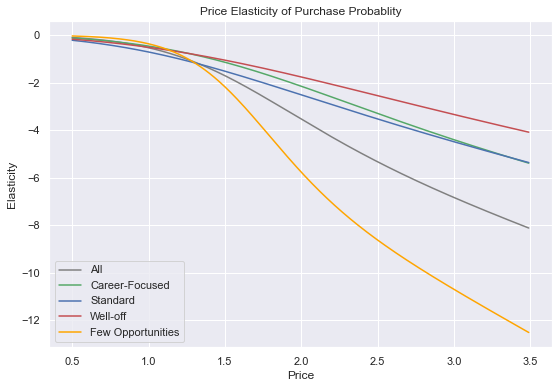

In [18]:
plt.figure(figsize=(9,6))
plt.plot(price_range, temp_df['PE_ALL'], color='grey')
plt.plot(price_range, temp_df['PE_S0'], color='g')
plt.plot(price_range, temp_df['PE_S1'], color='b')
plt.plot(price_range, temp_df['PE_S2'], color='r')
plt.plot(price_range, temp_df['PE_S3'], color='orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probablity')
plt.legend(['All','Career-Focused','Standard','Well-off','Few Opportunities'])
plt.show()

***As obvious, increase in price tend to lower the elasticity, but upto 1.1 we see a gradual decrease. <br>
Increase in price from 0-1.25 --> gradual drop in purchase probability <br>
Increse in price above 1.25 --> drasticaly reduce the purchase probability***